In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from PIL import ImageFile
from imageio import imread
import sys

In [2]:
ttfiles = os.listdir("/aerialphotos")

In [3]:
ttfiles.remove('.DS_Store')

In [4]:
#len(ttfiles)

In [5]:
import image_slicer

#for i in ttfiles:
    tiles = image_slicer.slice("/aerialphotos/"+str(i), 32)

IndentationError: unexpected indent (<ipython-input-5-0b9f880f93a0>, line 4)

In [6]:
files="/aerialphotos/photo_slices/photos/"
cnt_files = len(os.listdir("/aerialphotos/photo_slices/photos/half"))

In [7]:
cnt_files

1728

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_278 (Conv2D)          (None, 32, 32, 16)        160       
_________________________________________________________________
leaky_re_lu_156 (LeakyReLU)  (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_147 (Dropout)        (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_279 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_158 (Bat (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_157 (LeakyReLU)  (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_148 (Dropout)        (None, 16, 16, 32)        0         
__________

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.066971, acc.: 39.81%] [G loss: 0.523480]
1 [D loss: 0.882389, acc.: 56.25%] [G loss: 0.641108]
2 [D loss: 0.783317, acc.: 59.26%] [G loss: 0.661955]
3 [D loss: 0.746735, acc.: 59.49%] [G loss: 0.802529]
4 [D loss: 0.752677, acc.: 56.25%] [G loss: 0.837264]
5 [D loss: 0.659184, acc.: 65.74%] [G loss: 1.014561]
6 [D loss: 0.525391, acc.: 75.00%] [G loss: 0.896240]
7 [D loss: 0.668796, acc.: 62.27%] [G loss: 0.724257]
8 [D loss: 0.422472, acc.: 86.34%] [G loss: 0.691994]
9 [D loss: 0.429164, acc.: 82.64%] [G loss: 0.728314]
10 [D loss: 0.303691, acc.: 91.90%] [G loss: 0.872620]
11 [D loss: 0.632695, acc.: 64.81%] [G loss: 1.435005]
12 [D loss: 0.184725, acc.: 98.15%] [G loss: 2.067985]
13 [D loss: 0.274432, acc.: 94.68%] [G loss: 1.560136]
14 [D loss: 0.467511, acc.: 77.31%] [G loss: 1.403645]
15 [D loss: 0.357087, acc.: 86.57%] [G loss: 1.974368]
16 [D loss: 0.242945, acc.: 94.21%] [G loss: 2.103615]
17 [D loss: 0.185213, acc.: 97.45%] [G loss: 2.010439]
18 [D loss: 0.258618

KeyboardInterrupt: 

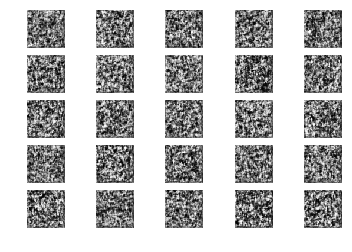

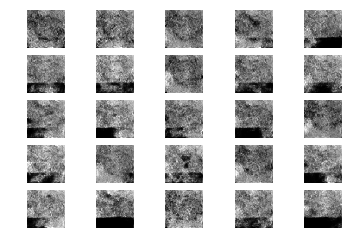

In [61]:
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def the_gan(epochs, batch_size, sample_epoch):
    
    photo_rows = 64
    photo_cols = 64
    channels = 1
    photo_shape = (photo_rows, photo_cols, channels)
    latent_dim = 100

    optimizer = Adam(0.0002, 0.5)
    

    def the_generator():

        model = Sequential()

        model.add(Dense(128 * 16 * 16, activation="relu", input_dim=latent_dim))
        model.add(Reshape((16, 16, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(latent_dim,))
        pic = model(noise)

        return Model(noise, pic)

    def the_discriminator():

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=photo_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        pic = Input(shape=photo_shape)
        validity = model(pic)

        return Model(pic, validity)

    def train_gan(epochs, batch_size=128, sample_epoch=50):
           
        def save_pics(epoch):
            h, w = 5, 5
            noise = np.random.normal(0, 1, (h * w, latent_dim))
            gen_pics = generator.predict(noise)

            # Rescale images 0 - 1
            gen_pics = 0.5 * gen_pics + 0.5

            fig,ax = plt.subplots(h, w)
            cnt = 0
            for i in range(h):
                for j in range(w):
                    ax[i,j].imshow(gen_pics[cnt, :,:,0], cmap='gray')
                    ax[i,j].axis('off')
                    cnt += 1
            fig.savefig("epoch_%d.png" % epoch)


     # compile discriminator
        discriminator = the_discriminator()
        discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

        # Build generator
        generator = the_generator()

        # generator inputs and outputs
        z = Input(shape=(latent_dim,))
        pic = generator(z)

        # For combined model don't train discriminator
        discriminator.trainable = False

        # discriminator inputs and outputs
        validity = discriminator(pic)

        # Generator is trained by discriminators validity score
        combined = Model(z, validity)
        combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # get dataset
        files="/Users/Maggie/Downloads/aerialphotos/photo_slices/"
        cnt_files = len(os.listdir("/Users/Maggie/Downloads/aerialphotos/photo_slices/photos"))
        # preprocessing for Keras 
        real_datagen = ImageDataGenerator(#the pixels are rgb so values between 0 and 255 must be normalized
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)
        real_generator = real_datagen.flow_from_directory(
                files,  # this is the target directory
                target_size=(photo_rows, photo_cols),  # all images will be resized to 350x350
                batch_size=cnt_files,
                color_mode = "grayscale",
                class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

        real_batch = next(real_generator)

        # last batch can be small
        if len(real_batch) != batch_size:
                real_batch = next(real_generator)

        assert real_batch[0].shape == (cnt_files, photo_rows, photo_cols, 1), real_batch[0].shape

        photos = real_batch[0]
        
        # Standardize photo arrays
        photostd = (photos.astype(np.float32) - 127.5) / 127.5

        X_train = photostd
        
        # make arrays for real and fake
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        


        for epoch in range(epochs):

             ##Training discriminator

            # Select a random batch of images
            index = np.random.randint(0, X_train.shape[0], batch_size)
            pics = X_train[index]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_pics = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(pics, valid)
            d_loss_fake = discriminator.train_on_batch(gen_pics, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

             
                ##Training generator

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train generator
            g_loss = combined.train_on_batch(noise, valid)

            
            # Print
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            if epoch % sample_epoch == 0:
                save_pics(epoch)
            
    train_gan(epochs, batch_size, sample_epoch)
    
the_gan(epochs=201, batch_size=216, sample_epoch=100)